# **Step 1 : 載入路徑資訊**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving eil51.tsp.txt to eil51.tsp (1).txt


In [0]:
import pandas as pd

In [4]:
#讀入檔案
f='./eil51.tsp.txt'
point = pd.read_csv(f,
                    sep=' ',
                    skiprows=6, skipfooter=1,
                    engine='python',
                    header=None,
                    names=('N', 'x', 'y'))
point.head()

,N,x,y
0,1,37,52
1,2,49,49
2,3,52,64
3,4,20,26
4,5,40,30


# **Step2: 前處理(計算節點間的路徑長與總路徑長)**

In [0]:
from math import pow, sqrt
import random

In [0]:
distance51=[]#存放路徑長

In [0]:
#計算各個節點間的距離
def calDistance(point):
    distance_all = []
    for p1 in point.index :
        distance=[]
        for p2 in point.index:
            # dis = 開更號(a^2 +b^2)
            distance.append(sqrt( pow( int(point.x[p1]) - int(point.x[p2]), 2) + pow( int(point.y[p1]) - int(point.y[p2]), 2)))

        distance_all.append(distance)
    return distance_all

In [8]:
distance51 = calDistance(point)
print(distance51)

[[0.0, 12.36931687685298, 19.209372712298546, 31.064449134018133, 22.20360331117452, 16.76305461424021, 22.825424421026653, 11.661903789690601, 24.20743687382041, 34.0147027033899, 12.083045973594572, 20.8806130178211, 41.86884283091664, 26.92582403567252, 36.013886210738214, 18.601075237738275, 30.675723300355934, 27.586228448267445, 45.79301256742124, 20.8806130178211, 26.92582403567252, 7.0710678118654755, 21.587033144922902, 29.0, 33.1058907144937, 18.867962264113206, 8.06225774829855, 16.15549442140351, 21.37755832643195, 32.64965543462902, 17.0, 6.082762530298219, 42.95346318982906, 30.610455730027933, 27.313000567495326, 31.064449134018133, 30.4138126514911, 18.788294228055936, 43.04648650006177, 56.0357029044876, 44.204072210600685, 44.94441010848846, 34.17601498127012, 37.656340767525464, 42.04759208325728, 13.92838827718412, 23.323807579381203, 12.36931687685298, 26.40075756488817, 24.20743687382041, 13.892443989449804], [12.36931687685298, 0.0, 15.297058540778355, 37.0135110

In [0]:
#計算總路徑長度
def calPathLength(path):
    p1=None
    lenght = 0
    for p2 in path:
        if p1 != None: 
            lenght += distance51[p1][p2]
        p1=p2
    return lenght

# **Step3:定義螞蟻行動模式**

螞蟻參數設定


1.   起始位置
2.   當前位置
3.   選擇action的閥值
4. 城市總數量
5.alpha, beta :用以決定費洛蒙與距離相對重要性之參數
6.費洛蒙的衰減參數
7.線段間的距離


In [0]:
class ant():
    def __init__(self, startCity, currentCity, qzero, cityCount,
               a, b, p, distance):
      self.startCity = startCity #開始的城市位置(起始位置)
      self.currentCity = currentCity # 當前所在的城市
      self.qzero = qzero #參數，選擇行動方式的閥值
      self.cityCount=cityCount #城市總數量
      self.a=a#參數
      self.b=b#參數
      self.p=p#費洛蒙衰減參數
      self.distance = distance#線段間的距離

### 搜索路徑 (路徑總長度, 線段上的費洛蒙濃度)

In [0]:
class ant(ant):
    def search(self, lenght, linePher):
        visitCity=[]
        visitCity.append(self.startCity)
        self.currentCity = self.startCity
        nextCity=None
        
        while len(visitCity) != self.cityCount:
            copyCurrentCity = self.currentCity
            #選擇下一個城市
            nextCity = self.choose(visitCity, linePher)
            if nextCity !=None:
                #移動到下一個城市
                visitCity = self.moveToNextCity(nextCity,visitCity)
                #更新某線段的費洛蒙值
                linePher = self.updataPher(copyCurrentCity, nextCity, lenght, linePher)
        #2-opt
        visitCity = self.two_opt_search(visitCity)
        #更新某線段的費洛蒙值
        #linePher = self.updataPher(copyCurrentCity, nextCity, lenght, linePher)
               
        #回到原點
        copyCurrentCity = self.currentCity
        visitCity = self.moveToNextCity(self.startCity,visitCity)
        linePher = self.updataPher(copyCurrentCity, self.startCity, lenght, linePher)
        #print (visitCity)
        return visitCity, linePher

### :::概率轉換規則:::選擇下一個城市(拜訪過的城市，線段費洛蒙)

In [0]:
 class ant(ant):   
    def choose(self, visitCity, linePher):
        # 隨機get某數
        p=random.random()
        selectCity=None
        #檢查是否大於閥值(qzero)
        if p > self.qzero:
            #:::選擇探索路徑::::
            sum=0#分母
            probability = 0.0 #概率的區間點，p 落在哪個區間段，則該點是轉移的方向
            rand = random.random()#生成一個隨機數,用來判斷落在哪個區間段


            #計算分母
            for nextCity in range(self.cityCount):
                #檢查是否沒有拜訪過
                if not nextCity in visitCity:
                    #sum+= ([費洛蒙_(i,j)]^a)*([1/線段_(i,j)]^b)
                    sum += self.transition(linePher, self.currentCity, nextCity)
            
            #計算概率= ([費洛蒙_(i,j)]^a)*([1/線段_(i,j)]^b)/分母
            for nextCity in range(self.cityCount):
                #檢查是否沒有拜訪過
                if (not nextCity in visitCity) and sum > 0 :
                    probability += (self.transition(linePher, self.currentCity, nextCity)/sum)
                    if probability >= rand or (rand > 0.9999 and probability >0.9999):
                        selectCity = nextCity
                        break 
        else:
            #:::選擇追隨前人螞蟻祖先留下的足跡:::
            probability = -1.0
            for nextCity in range(self.cityCount):
              
                #檢查是否沒有拜訪過
                if not nextCity in visitCity:
                    #概率 = ([費洛蒙_(i,j)]^a)*([1/線段_(i,j)]^b)
                    prob = self.transition(linePher, self.currentCity, nextCity)
                    
                    #比較各個城市概率，取較高者當作下一個將前往的城市
                    #Max
                    if prob > probability:
                        probability = prob
                        selectCity = nextCity
        return selectCity

### 計算線段費洛蒙 (當前線段費洛蒙,目前所在的城市,下一個城市)

In [0]:
class ant(ant):   
    def transition(self,linePher, currentCity, nextCity):
             #概率 = ([費洛蒙_(i,j)]^a)*([1/線段_(i,j)]^b)
            return pow(linePher[currentCity][nextCity], self.a) * pow((1/self.distance[currentCity][nextCity]),self.b)

###移動到下一個城市 (下一個城市, 已拜訪的城市)

In [0]:
class ant(ant):    
    def moveToNextCity(self, nextCity, visitCity):
        #為了更薪 visitCity
        visitCity.append(nextCity)
        #將目前的城市改成下一個城市
        self.currentCity = nextCity
        return visitCity

### 2-opt search 


>              ::::1-2-3-4::::
       if 1-2 + 3-4 > 1-3 + 2-4 :
          change



In [0]:
class ant(ant):
  def two_opt_search(self, visitCity):
        for i in range (self.cityCount):
            for j in range(self.cityCount-1,i,-1):
                if i == 0:
                    continue
                
                currentCity1 = visitCity[i] #2
                preCity1 =visitCity[(i-1)%self.cityCount]#1
                currentCity2 = visitCity[j] #3
                nextCity2 = visitCity[(j+1)%self.cityCount]#4
                
                #1-2 + 3-4
                currentLenght = self.distance[preCity1][currentCity1] + self.distance[currentCity2][nextCity2]  
                #1-3 + 2-4
                nextLenght = self.distance[preCity1][currentCity2] + self.distance[currentCity1][nextCity2] 
                
                if nextLenght < currentLenght:
                    updataVisitCity = visitCity[i:j+1]
                    visitCity[i:j+1] = updataVisitCity[::-1]
        return visitCity  

### 更新費洛蒙(當前所在的城市，下一個城市，路徑總長度，線段上的費洛蒙)

In [0]:
 class ant(ant):
    def updataPher(self, currentCity, nxteCity, lenght, linePher):
        # (1-p)(線段上的費洛蒙濃度) + p(1/城市數量*拜訪城市的總長度)
        updataLinePher = (1.0 - self.p) * linePher[currentCity][nxteCity]+(self.p)*(1.0/(self.cityCount*lenght))
        linePher[currentCity][nxteCity] = updataLinePher
        linePher[nxteCity][currentCity] = updataLinePher
        return linePher

# **Step4:定義蟻群系統(ACO)**




In [0]:
class ACO():
    
    def __init__(self, distance, localP=0.8,globalP=0.8, ant_count=51, a=1, b=4,qzero=0.01, iter=1000):
        self.distance = distance#線段距離
        self.localP = localP#費洛蒙衰減參數(區域)
        self.globalP = globalP#費洛蒙衰減參數(全域)
        self.ant_count = ant_count#螞蟻數量
        self.a = a#參數
        self.b = b#參數
        self.qzero =qzero#選擇action的閥值
        self.iter=iter# run times
        
        #計算初始線段上的費洛蒙
        path =[]
        for i in range(len(point)-1):
          path.append(i)
        path.append(0)# 尾-頭
        
        #調用 calPathLength
        self.lenght = calPathLength(path)
        
        #調用 計算費洛蒙的涵式(總線段數，長度)
        pher = 1/(len(self.distance)+1 * self.lenght)#+1 : 尾-頭
    
        linePher=[]#每條線段上的費洛蒙濃度
        for city1 in range(len(self.distance)+1) :
            line=[]
            for city2 in range(len(self.distance)+1):
                # dis = 開更號(a^2 +b^2)
                line.append(pher)
            linePher.append((line))
        self.linePher=linePher

In [0]:
class ACO(ACO): 
    def slove(self, point):
            record =[]
            record.append(self.lenght)
            localBestLenght = self.lenght
            localBestPath=[]
            localPher=[]

            globalBestLenght = self.lenght
            globalaBestPath=[]
            globalPher =[]
            #初始化螞蟻們的起始城市
            ants=[]
            for i in range(self.ant_count):
                #宣告 ant 類別 (起始的城市,目前的城市, 閥值, 螞蟻數量, 城市數量, alpha, beta, 費洛蒙衰減值(區域), 費洛蒙衰減值(全域), 線段長度)
                ants.append( ant(i% len(point), i% len(point), self.qzero, len(point),
                            self.a,self.b,self.localP,self.distance) )
            #print(len(ants))

            #迴圈數
            for i in range(self.iter):
                #逐一指派螞蟻搜尋
                for antIndex in range(self.ant_count):
                    #搜尋城市
                    path, linePher = ants[antIndex].search(self.lenght,self.linePher)
                    #:::區域:::  螞蟻群最佳路徑檢查
                    localLenght = calPathLength(path)
                    if localLenght < localBestLenght :
                        localBestLenght = localLenght
                        localBestPath = path
                        localPher = linePher
               # print('Local:%f'%(localBestLenght))
                #print(path)
                
                #:::全域::: 整體最佳路徑檢查
                if localBestLenght < globalBestLenght  :
                    globalBestLenght = localBestLenght
                    globalaBestPath = localBestPath
                    globalPher = localPher


                print('Global %d : %f'%(i,globalBestLenght))
                #更新全體的費洛蒙
                p1 = None
                for p2 in range(len(point)):
                    if p1 != None:
                        pher = (1.0 - self.globalP) * globalPher[p1][p2]+self.globalP*(1/globalBestLenght)
                        self.linePher[p1][p2] = pher
                        self.linePher[p2][p1] =self.linePher[p1][p2]
                    p1=p2
                record.append(globalBestLenght)
            return globalaBestPath, globalBestLenght, record

###執行TSP蟻群系統

In [41]:
aco = ACO(distance = distance51, localP=0.01, globalP=0.5, ant_count= len(point), a=1, b=18 ,iter=1000,qzero=0.01)
bestPath,bestLen ,record = aco.slove(point)

Global 0 : 445.843862
Global 1 : 436.519549
Global 2 : 436.519549
Global 3 : 435.800511
Global 4 : 435.800511
Global 5 : 435.800511
Global 6 : 435.800511
Global 7 : 435.667968
Global 8 : 435.667968
Global 9 : 435.667968
Global 10 : 435.667968
Global 11 : 435.667968
Global 12 : 435.667968
Global 13 : 435.667968
Global 14 : 435.667968
Global 15 : 435.667968
Global 16 : 435.667968
Global 17 : 435.667968
Global 18 : 435.667968
Global 19 : 435.667968
Global 20 : 435.667968
Global 21 : 435.667968
Global 22 : 435.017992
Global 23 : 435.017992
Global 24 : 435.017992
Global 25 : 434.555680
Global 26 : 434.555680
Global 27 : 434.555680
Global 28 : 434.555680
Global 29 : 434.555680
Global 30 : 434.555680
Global 31 : 434.555680
Global 32 : 434.555680
Global 33 : 434.555680
Global 34 : 434.555680
Global 35 : 434.555680
Global 36 : 434.555680
Global 37 : 434.555680
Global 38 : 434.555680
Global 39 : 434.555680
Global 40 : 434.555680
Global 41 : 434.555680
Global 42 : 434.555680
Global 43 : 434.55568

#Strp5: 劃出最佳路徑圖

In [0]:
import pylab as pl

Best Path : [3, 17, 13, 24, 12, 40, 39, 18, 41, 43, 16, 36, 14, 44, 32, 38, 9, 48, 4, 37, 10, 31, 0, 21, 1, 15, 49, 8, 29, 33, 20, 28, 19, 34, 35, 2, 27, 30, 7, 25, 6, 42, 23, 22, 47, 5, 26, 50, 45, 11, 46, 3]
Shortest Path Length :  428.98164717220675


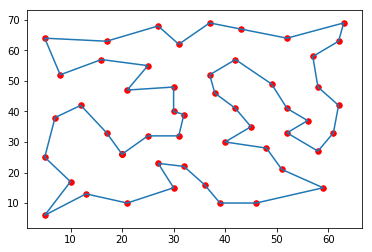

In [42]:
print('Best Path :',bestPath)
print('Shortest Path Length : ', bestLen)
pl.clf()
x = []
y = []

for city in bestPath:
    x.append(point.x[city])
    y.append(point.y[city])
    
x.append(x[0])
y.append(y[0])
pl.plot(x, y)
pl.scatter(x, y, s=30, c='r')
pl.pause(0.01)


### 探討螞蟻數量與收斂速度關係

In [29]:
ant_count=[3,30 ,51 ,100]
record_=[]

for count in ant_count: 
  aco = ACO(distance = distance51, localP=0.01, globalP=0.5, ant_count=count, a=1, b=15 ,iter=1000,qzero=0.01)
  bestPath,bestLen ,record = aco.slove(point)
  record_.append((record))

Global 0 : 462.023996
Global 1 : 450.535602
Global 2 : 449.306912
Global 3 : 449.306912
Global 4 : 449.306912
Global 5 : 447.180689
Global 6 : 447.180689
Global 7 : 447.180689
Global 8 : 447.180689
Global 9 : 442.444270
Global 10 : 442.444270
Global 11 : 442.444270
Global 12 : 442.444270
Global 13 : 442.444270
Global 14 : 442.444270
Global 15 : 442.444270
Global 16 : 442.444270
Global 17 : 442.444270
Global 18 : 442.444270
Global 19 : 442.444270
Global 20 : 442.444270
Global 21 : 442.444270
Global 22 : 442.444270
Global 23 : 435.607322
Global 24 : 435.607322
Global 25 : 435.607322
Global 26 : 435.607322
Global 27 : 435.607322
Global 28 : 435.607322
Global 29 : 435.607322
Global 30 : 435.607322
Global 31 : 435.607322
Global 32 : 435.607322
Global 33 : 435.607322
Global 34 : 435.607322
Global 35 : 433.752952
Global 36 : 433.752952
Global 37 : 433.752952
Global 38 : 433.752952
Global 39 : 433.752952
Global 40 : 433.752952
Global 41 : 433.752952
Global 42 : 433.752952
Global 43 : 433.75295

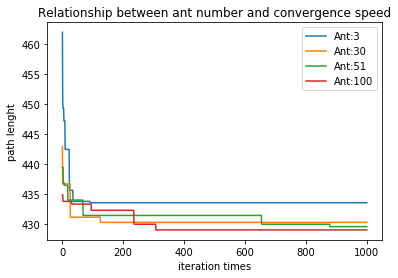

In [34]:
pl.clf()
#螞蟻數量與收斂速度關係圖
pl.title('Relationship between ant number and convergence speed')

pl.xlabel('iteration times')
pl.ylabel('path lenght')

antIndex=0
for r in record_:
    x = []
    y = []
    for i in range(1,len(r)):
      x.append(i)
      y.append(r[i])
    text = 'Ant:'+str(ant_count[antIndex])
    pl.plot(x, y ,label=text)
    antIndex += 1
   # pl.scatter(x, y, s=30, c='r')
pl.legend()
pl.show()

###探討beta與收斂速度的關係

In [35]:
beta =[1,5,10,15,20,25,30]
record_=[]

for b in beta: 
  aco = ACO(distance = distance51, localP=0.01, globalP=0.5, ant_count=51, a=1, b=b ,iter=1000,qzero=0.01)
  bestPath,bestLen ,record = aco.slove(point)
  record_.append((record))

Global 0 : 482.376314
Global 1 : 481.498037
Global 2 : 467.787640
Global 3 : 467.787640
Global 4 : 467.787640
Global 5 : 467.787640
Global 6 : 467.787640
Global 7 : 467.787640
Global 8 : 467.787640
Global 9 : 467.787640
Global 10 : 467.787640
Global 11 : 467.787640
Global 12 : 467.787640
Global 13 : 467.787640
Global 14 : 465.034582
Global 15 : 465.034582
Global 16 : 465.034582
Global 17 : 465.034582
Global 18 : 465.034582
Global 19 : 465.034582
Global 20 : 465.034582
Global 21 : 465.034582
Global 22 : 459.192310
Global 23 : 459.192310
Global 24 : 459.192310
Global 25 : 459.192310
Global 26 : 459.192310
Global 27 : 459.192310
Global 28 : 459.192310
Global 29 : 459.192310
Global 30 : 459.192310
Global 31 : 459.192310
Global 32 : 459.192310
Global 33 : 459.192310
Global 34 : 459.192310
Global 35 : 459.192310
Global 36 : 459.192310
Global 37 : 459.192310
Global 38 : 459.192310
Global 39 : 459.192310
Global 40 : 459.192310
Global 41 : 459.192310
Global 42 : 459.192310
Global 43 : 459.19231

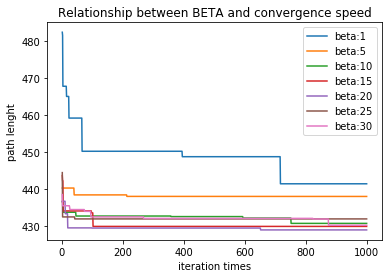

In [36]:
pl.clf()
#beta與收斂速度的關係圖
pl.title('Relationship between BETA and convergence speed')

pl.xlabel('iteration times')
pl.ylabel('path lenght')

betaIndex=0
for r in record_:
    x = []
    y = []
    for i in range(1,len(r)):
      x.append(i)
      y.append(r[i])
    text = 'beta:'+str(beta[betaIndex])
    pl.plot(x, y ,label=text)
    betaIndex += 1
   # pl.scatter(x, y, s=30, c='r')
pl.legend()
pl.show()

###探討alpha與收斂速度的關係圖

In [38]:
alpha =[1,5,10,15,20]
record_=[]

for a in alpha: 
  aco = ACO(distance = distance51, localP=0.01, globalP=0.5, ant_count=51, a=a, b=20 ,iter=1000,qzero=0.01)
  bestPath,bestLen ,record = aco.slove(point)
  record_.append((record))

Global 0 : 444.502025
Global 1 : 440.742028
Global 2 : 440.703567
Global 3 : 438.043799
Global 4 : 438.043799
Global 5 : 438.043799
Global 6 : 438.043799
Global 7 : 438.043799
Global 8 : 438.043799
Global 9 : 438.043799
Global 10 : 438.043799
Global 11 : 438.043799
Global 12 : 438.043799
Global 13 : 438.043799
Global 14 : 438.043799
Global 15 : 438.043799
Global 16 : 438.043799
Global 17 : 438.043799
Global 18 : 438.043799
Global 19 : 438.043799
Global 20 : 438.043799
Global 21 : 438.043799
Global 22 : 438.043799
Global 23 : 438.043799
Global 24 : 438.043799
Global 25 : 434.538137
Global 26 : 434.538137
Global 27 : 434.538137
Global 28 : 434.538137
Global 29 : 434.538137
Global 30 : 434.538137
Global 31 : 434.538137
Global 32 : 434.538137
Global 33 : 434.538137
Global 34 : 434.538137
Global 35 : 434.538137
Global 36 : 434.538137
Global 37 : 434.538137
Global 38 : 434.538137
Global 39 : 434.538137
Global 40 : 434.538137
Global 41 : 434.538137
Global 42 : 434.538137
Global 43 : 434.53813

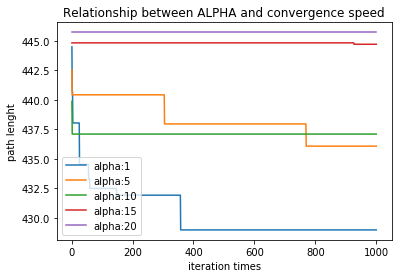

In [40]:
pl.clf()
#alpha與收斂速度的關係圖
pl.title('Relationship between ALPHA and convergence speed')

pl.xlabel('iteration times')
pl.ylabel('path lenght')

alphaIndex=0
for r in record_:
    x = []
    y = []
    for i in range(1,len(r)):
      x.append(i)
      y.append(r[i])
    text = 'alpha:'+str(alpha[alphaIndex])
    pl.plot(x, y ,label=text)
    alphaIndex += 1
   # pl.scatter(x, y, s=30, c='r')
pl.legend()
pl.show()